In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output

#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))




def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)

def Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus,Fourier_minous
def Toeplitz_matrix(Fourier_plus,L):
    First_column=np.roll(Fourier_plus,-1)[::-1][:L]
    First_row = Fourier_plus[:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    First_column=Fourier_minous[::-1][:L]
    Last_row=np.roll(Fourier_minous,L-1)[::-1][:L]
    return hankel(First_column,Last_row)


def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))/N_size

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L,N_size=N_size):
    return (Toeplitz_matrix(F_plus,L)+Hankel_matrix(F_minous,L))/N_size

# implementation with Numba

In [156]:
from numba import jit

@jit(nopython=True)
def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
@jit(nopython=True)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
@jit(nopython=True)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
@jit(nopython=True)
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))
@jit(nopython=True)
def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

@jit(nopython=True)
def Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    M_plus=[]
    M_minous=[]
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        for i in x:
            M_minous.append((m_cos[np.abs(int(i))]-m_cos[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))))
            M_plus.append((m_cos[np.abs(int(i))]+m_cos[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))))
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        for i in x:
            M_minous.append((m_cos[np.abs(int(i))]-m_cos[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))))
            M_plus.append((m_cos[np.abs(int(i))]+m_cos[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))))
    return np.array(M_plus),np.array(M_minous)
def Fourier_transform(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    Mplusband,Mminousband=Get_Bands_Matrix(Gamma,Lambda,N_size,beta,mu,Ground)
    Fourier_plus=np.fft.fft(np.fft.ifftshift(Mplusband))
    Fourier_minous=np.fft.fft(np.fft.ifftshift(Mminousband))
    return Fourier_plus,Fourier_minous

In [159]:
N_size=500001
a,b=Fourier_transform(N_size=N_size)

# Test with numba didn't work as expected

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output


#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))




def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)

def Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)

        M_minous=[((m_cos[np.abs(int(i))]-m_cos[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_cos[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        #m_cos=np.array(m_cos[1:][::-1]+m_cos)
        #m_sin=np.array(m_sin[1:][::-1]+m_sin)
        #M_plus=(m_cos+m_sin)*0.5
        #M_minous=(m_cos-m_sin)*0.5
        #x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        #Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        #Mplusband=M_plus*np.array(Mplusband)
        #Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        #Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)

        M_minous=[((m_cos[np.abs(int(i))]-m_cos[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_cos[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
        #m_cos=np.array(m_cos[1:][::-1]+m_cos)
        #m_sin=np.array(m_sin[1:][::-1]+m_sin)
        #M_plus=(m_cos+m_sin)*0.5
        #M_minous=(m_cos-m_sin)*0.5
        #x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        #Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        #Mplusband=M_plus*np.array(Mplusband)
        #Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        #Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus,Fourier_minous
def Toeplitz_matrix(Fourier_plus,L):
    First_column=np.roll(Fourier_plus,-1)[::-1][:L]
    First_row = Fourier_plus[:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    First_column=Fourier_minous[::-1][:L]
    Last_row=np.roll(Fourier_minous,L-1)[::-1][:L]
    return hankel(First_column,Last_row)


def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))/N_size

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L,N_size=N_size):
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))/N_size

In [2]:
tests=50
S_all_2=[]
L_max=251
for L in range(73,L_max,2):
    print("L=",L)
    S_aux=[]
    for i in range(tests):
        F_plus,F_minous=Get_Bands_Matrix(N_size=N_size,Ground=False)
        New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
        S=np.linalg.svd(New_cov_matrix,full_matrices=False,compute_uv=False)
        S_aux.append(S)
    #print(np.array(S_aux))
    #print(np.mean(np.array(S_aux),axis=0))
    S_all_2.append(np.mean(S_aux,axis=0))

L= 73
L= 75
L= 77
L= 79
L= 81
L= 83
L= 85
L= 87
L= 89
L= 91
L= 93
L= 95
L= 97
L= 99
L= 101
L= 103
L= 105
L= 107
L= 109
L= 111
L= 113
L= 115
L= 117
L= 119
L= 121
L= 123
L= 125
L= 127
L= 129
L= 131
L= 133
L= 135
L= 137
L= 139
L= 141
L= 143
L= 145
L= 147
L= 149
L= 151
L= 153
L= 155
L= 157
L= 159
L= 161
L= 163
L= 165
L= 167
L= 169
L= 171
L= 173
L= 175
L= 177
L= 179
L= 181
L= 183
L= 185
L= 187
L= 189
L= 191
L= 193
L= 195
L= 197
L= 199
L= 201
L= 203
L= 205
L= 207
L= 209
L= 211
L= 213
L= 215
L= 217
L= 219
L= 221
L= 223
L= 225
L= 227
L= 229
L= 231
L= 233
L= 235
L= 237
L= 239
L= 241
L= 243
L= 245
L= 247
L= 249


In [3]:
with open("Singular_values/Singular_values.txt","a") as f:
    for i in range(len(S_all_2)):
        for j in range(len(S_all_2[i])):   
            if j == len(S_all_2[i]) -1 :
                f.write(str(S_all_2[i][j])+"\n")
            else:
                f.write(str(S_all_2[i][j])+",")
    f.close()

In [4]:
with open("Singular_values/Singular_values.txt","r") as f:
    Singular_values_read=[]
    for i in f.readlines():
        Singular_values_read.append((np.array(i[:-1].split(","),dtype=np.float)))

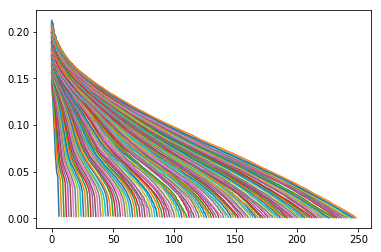

In [5]:
for i in Singular_values_read:
    plt.plot(i)
plt.show()

In [ ]:
plt.imshow(expm((O_1@np.diag(x)@O_2)).real,cmap="RdBu")
    #plt.colorbar()
    plt.show()
    time.sleep(0.5)